In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from pathlib import Path

In [2]:
# function to annotate seaborn scatterplots with pearson correlation coefficient
def annotate(data, **kws):
    x = data['sc'].values
    y = data['vm'].values
    msk = np.isfinite(x) & np.isfinite(y)
    r, p = sp.stats.pearsonr(x[msk], y[msk])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

In [3]:
# see deconv.py
def lookup(model_call, sample_entry):
    if model_call == "all":
        reg_model = "All"
    elif model_call == "condition":
        if sample_entry["Condition"] == "Control":
            reg_model = "Control"
        elif sample_entry["Condition"] == "MS":
            reg_model = "MS"
        else:
            raise ValueError("Unknown condition")
    elif model_call == "lesion_type":
        if sample_entry["lesion_type"] == "Ctrl":
            reg_model = "Control"
        elif sample_entry["lesion_type"] == "CI":
            reg_model = "CI"
        elif sample_entry["lesion_type"] == "CA":
            reg_model = "CA"
        elif sample_entry["lesion_type"] == "A":
            reg_model = "A"
        else:
            raise ValueError("Unknown lesion type")
    else:
        raise ValueError("Unknown model")
    return reg_model

In [4]:
def get_sc_proportions(meta):
    return (meta
     .groupby(['sample_id', 'cell_types'])[['sample_id']]
     .count()
     .rename({'sample_id': 'n'}, axis=1)
     .reset_index()
     .assign(sc=lambda x: x['n'] / x.groupby('sample_id')['n'].transform('sum'))
     .drop('n', axis=1)
    )


In [5]:
def get_vis_proportions(model_call, method, sample_meta, measure, path_deconv):
    assert model_call in ["all", "condition",]
    assert method in ["cellranger"]
    assert measure in ["abunds"]
    df_list = []
    for sample_id in os.listdir(path_deconv / method):
        sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]
        suffix = lookup(model_call, sample_entry)
        for quantile in ["q05_cell_abundance_w_sf", "means_cell_abundance_w_sf", "q95_cell_abundance_w_sf"]:
            name = quantile.split("_")[0]
            df = pd.read_csv(path_deconv / method / sample_id / f"cell_abunds_{suffix}_{quantile}.csv", index_col=0)
            df = df.melt(value_vars=df.columns, ignore_index=False).reset_index()
            df["sample_id"] = sample_id 
            df["point_estimate"] = name
            df_list.append(df)

    df = pd.concat(df_list)
    
    df = df.drop("index", axis=1)
    df = df.rename({"value": "vm", "variable": "cell_types"}, axis=1)
    df = df.groupby(["sample_id", "point_estimate", "cell_types"]).sum().reset_index()
    df = df[["sample_id", "cell_types", "point_estimate", "vm"]]
    df['vm'] /= df.groupby(["sample_id", "point_estimate"])['vm'].transform('sum') # normalize the vm column per sample_id
    # check: df["quantile"].value_counts()

    return df

In [6]:
def get_correlation(model_call, method, samples_oi, group, sc_proportions, vis_proportions, replace_zero=0.001):
    assert group in ["cell_types", "sample_id"]
    assert model_call in ["all", "condition"]
    assert method in ["cellranger"]

    sc_prop = sc_proportions[method]
    vis_prop = vis_proportions[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])

    # current stupid fix
    df_na = df.loc[df.point_estimate.isna(), :].copy()
    df_na["one"] = "q05"
    df_na["two"] = "means"
    df_na["three"] = "q95"
    df_na.drop("point_estimate", axis=1, inplace=True)
    # pivot to long using one, two three
    df_na = df_na.melt(id_vars=["sample_id", "cell_types", "sc", "vm"], value_vars=["one", "two", "three"], var_name="to_drop", value_name="point_estimate").drop("to_drop", axis=1)
    df_na["vm"] = df_na["vm"].fillna(0)
    df_complete = df.loc[~df.point_estimate.isna(), :]
    df = pd.concat([df_complete, df_na])

    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))
    grouped_df = df.groupby([group, "point_estimate"])

    def pearson_corr(x):
        return x["sc"].corr(x["vm"], method="pearson")
    def spearman_corr(x):
        return x["sc"].corr(x["vm"], method="spearman")

    df_out = grouped_df.apply(pearson_corr).to_frame()
    df_out = df_out.rename({0: "Pearson_R"}, axis=1)
    df_out['Spearman_R'] = grouped_df.apply(spearman_corr)
    df_out["method"] = method
    df_out["model_call"] = model_call
    df_out.reset_index(inplace=True)

    return df_out

In [7]:
def plot_correlation(model_call, method, samples_oi, sc_proportions, vis_proportions, replace_zero=0.001, save_path=None, point_estimate="q05"):
    
    sc_prop = sc_proportions[method]
    vis_prop = vis_proportions[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])

    # current stupid fix
    df_na = df.loc[df.point_estimate.isna(), :].copy()
    df_na["one"] = "q05"
    df_na["two"] = "means"
    df_na["three"] = "q95"
    df_na.drop("point_estimate", axis=1, inplace=True)
    # pivot to long using one, two three
    df_na = df_na.melt(id_vars=["sample_id", "cell_types", "sc", "vm"], value_vars=["one", "two", "three"], var_name="to_drop", value_name="point_estimate").drop("to_drop", axis=1)
    df_na["vm"] = df_na["vm"].fillna(0)
    df_complete = df.loc[~df.point_estimate.isna(), :]
    df = pd.concat([df_complete, df_na])

    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))

    # subset based on point estimate
    df = df.loc[df.point_estimate == point_estimate, :]

    # Plot corrs per cell type
    g = sns.lmplot(x='sc', y='vm', data=df, col='cell_types', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_celltype')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_celltype.pdf'), dpi=300)

    # Plot corrs per sample id
    g = sns.lmplot(x='sc', y='vm', data=df, col='sample_id', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_sample')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_sample.pdf'), dpi=300)

In [8]:
# set up the paths
current_folder = globals()['_dh'][0]
path_ann = current_folder / ".." / ".." / "data" / "prc" / "sc"
path_deconv = current_folder / ".." / ".." / "data" / "prc" / "vis" / "c2l_out"
model_dir = current_folder / ".." / ".." / "data" / "prc" / "sc" / "c2l_model" / "cellranger"
output_path = current_folder / ".." / ".." / "out" / "deconvolution_eval_cellranger"
output_path.mkdir(parents=True, exist_ok=True)

sample_meta = pd.read_excel(current_folder / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")

In [9]:
get_sc_proportions(sc.read_h5ad(path_ann / f"annotated_cellranger.h5ad").obs)

,sample_id,cell_types,sc
0,CO37,Asrtos_r,0.028657
1,CO37,Astros,0.095616
2,CO37,Astros_c,0.002695
3,CO37,Astros_n,0.001844
4,CO37,B_cells,0.000000
...,...,...,...
242,MS586,Neurons,0.008911
243,MS586,OPC,0.042165
244,MS586,Oligos,0.655292
245,MS586,Stroma,0.004999


In [10]:
get_vis_proportions("all", "cellranger", sample_meta, "abunds", path_deconv)

,sample_id,cell_types,point_estimate,vm
0,CO37,Asrtos_r,means,0.029589
1,CO37,Astros,means,0.064875
2,CO37,Astros_c,means,0.006165
3,CO37,Astros_n,means,0.014485
4,CO37,B_cells,means,0.013662
...,...,...,...,...
853,MS94,Neurons,q95,0.154216
854,MS94,OPC,q95,0.051581
855,MS94,Oligos,q95,0.126703
856,MS94,Stroma,q95,0.045921


In [11]:
# check the regression models
condition = "Control"
tmp_out = model_dir / (condition + "_reg_model")
df = pd.read_csv(tmp_out / "inf_aver.csv")
print(df.columns[1:])

condition = "MS"
tmp_out = model_dir / (condition + "_reg_model")
df = pd.read_csv(tmp_out / "inf_aver.csv")
print(df.columns[1:])

Index(['Asrtos_r', 'Astros', 'Astros_c', 'Astros_n', 'Endothelia', 'Macros',
       'Microglia', 'Neurons', 'OPC', 'Oligos', 'Stroma', 'T_cells'],
      dtype='object')
Index(['Asrtos_r', 'Astros', 'Astros_c', 'Astros_n', 'B_cells', 'Endothelia',
       'Macros', 'Microglia', 'Neurons', 'OPC', 'Oligos', 'Stroma', 'T_cells'],
      dtype='object')


In [12]:
sc_proportions = {"cellranger": get_sc_proportions(sc.read_h5ad(path_ann / f"annotated_cellranger.h5ad").obs)}

In [13]:
vis_proportions = {"cellranger": {model_call: get_vis_proportions(model_call, "cellranger", sample_meta, measure="abunds", path_deconv=path_deconv) for model_call in ["all", "condition"]}}

In [14]:
samples_oi = set(list(sc_proportions.values())[0].sample_id) & set(list(list(vis_proportions.values())[0].values())[0].sample_id)

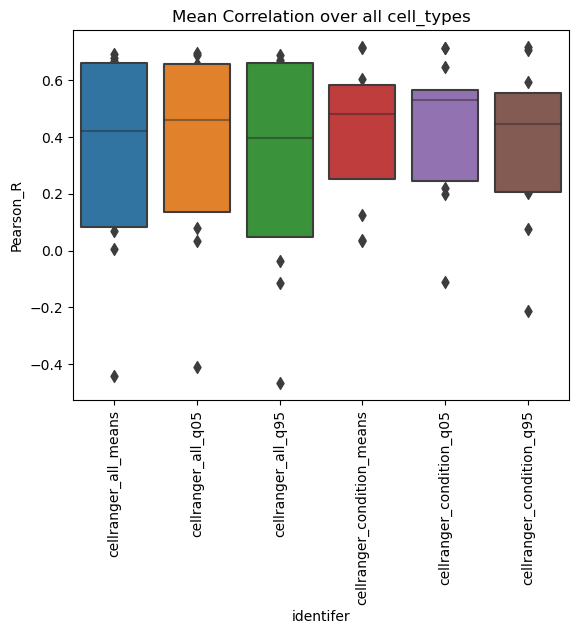

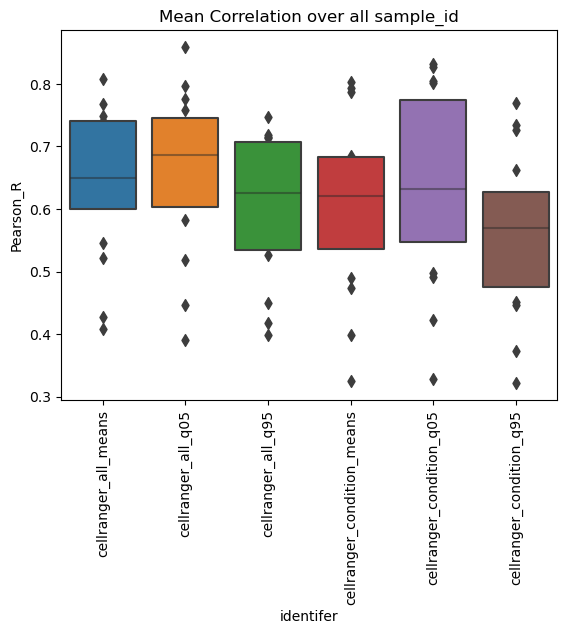

In [15]:
for group in ["cell_types", "sample_id"]:
    df_list = []
    for model_call in ["all", "condition"]:
        for method in ["cellranger"]:
            df_list.append(get_correlation(model_call, method, samples_oi, group=group, vis_proportions=vis_proportions, sc_proportions=sc_proportions))
    df = pd.concat(df_list)
    df["identifer"] = df["method"] + "_" + df["model_call"] + "_" + df["point_estimate"]
    df.reset_index(inplace=True)

    sns.boxenplot(data=df, x="identifer", y="Pearson_R")
    plt.xticks(rotation=90)
    plt.title(f"Mean Correlation over all {group}")
    plt.show()

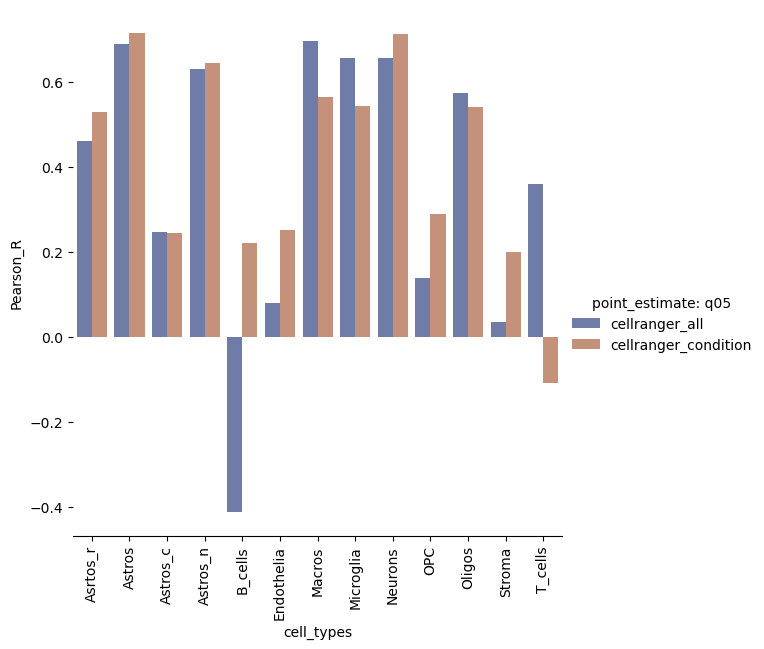

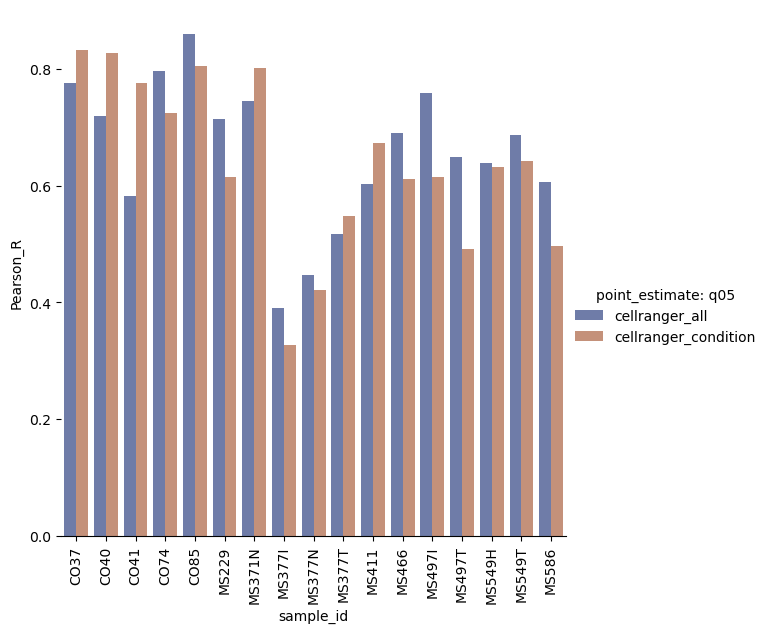

In [16]:
point_estimate = "q05"
for group in ["cell_types", "sample_id"]:
    #for metric in ["Pearson_R", "Spearman_R"]:
    for metric in ["Pearson_R"]:
        df_list = []
        for model_call in ["all", "condition"]:
            for method in ["cellranger"]:
                tmp_df = get_correlation(model_call, method, samples_oi, group=group, vis_proportions=vis_proportions, sc_proportions=sc_proportions)
                tmp_df = tmp_df.loc[tmp_df.point_estimate == point_estimate, :]
                df_list.append(tmp_df)
        df = pd.concat(df_list)
        df["identifer"] = df["method"] + "_" + df["model_call"]
        df.reset_index(inplace=True)

        g = sns.catplot(
            data=df,
            x=group, y=metric, hue="identifer",
            kind="bar", palette="dark", alpha=.6, height=6
        )
        g.despine(left=True)
        g.legend.set_title(f"point_estimate: {point_estimate}")
        g.set_xticklabels(rotation=90)
        g.savefig(output_path / f"barplot_{group}_{metric}_{point_estimate}.pdf")

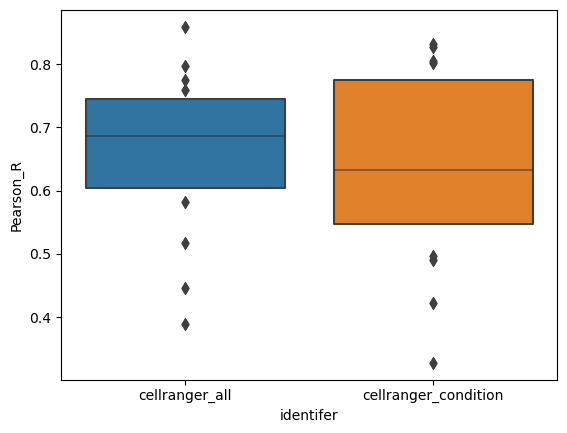

In [17]:
point_estimate = "q05"
group = "sample_id"
df_list = []
for model_call in ["all", "condition"]:
    for method in ["cellranger"]:
        tmp_df = get_correlation(model_call, method, samples_oi, group=group, vis_proportions=vis_proportions, sc_proportions=sc_proportions)
        tmp_df = tmp_df.loc[tmp_df.point_estimate == point_estimate, :]
        df_list.append(tmp_df)
df = pd.concat(df_list)
df["identifer"] = df["method"] + "_" + df["model_call"]
df.reset_index(inplace=True)

sns.boxenplot(data=df, x="identifer", y="Pearson_R")
plt.show()

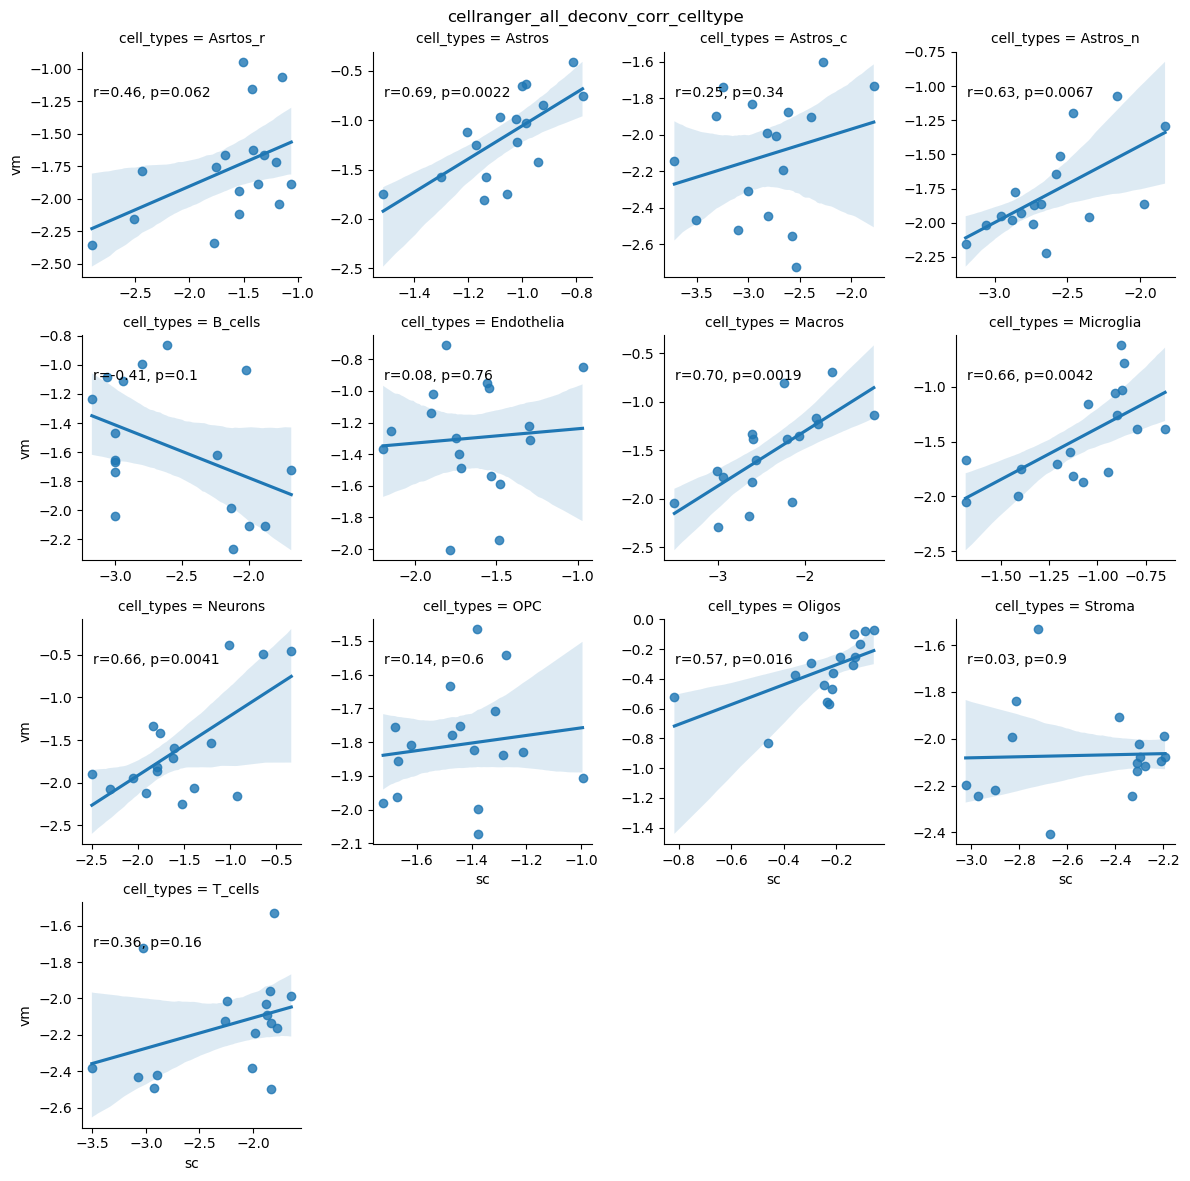

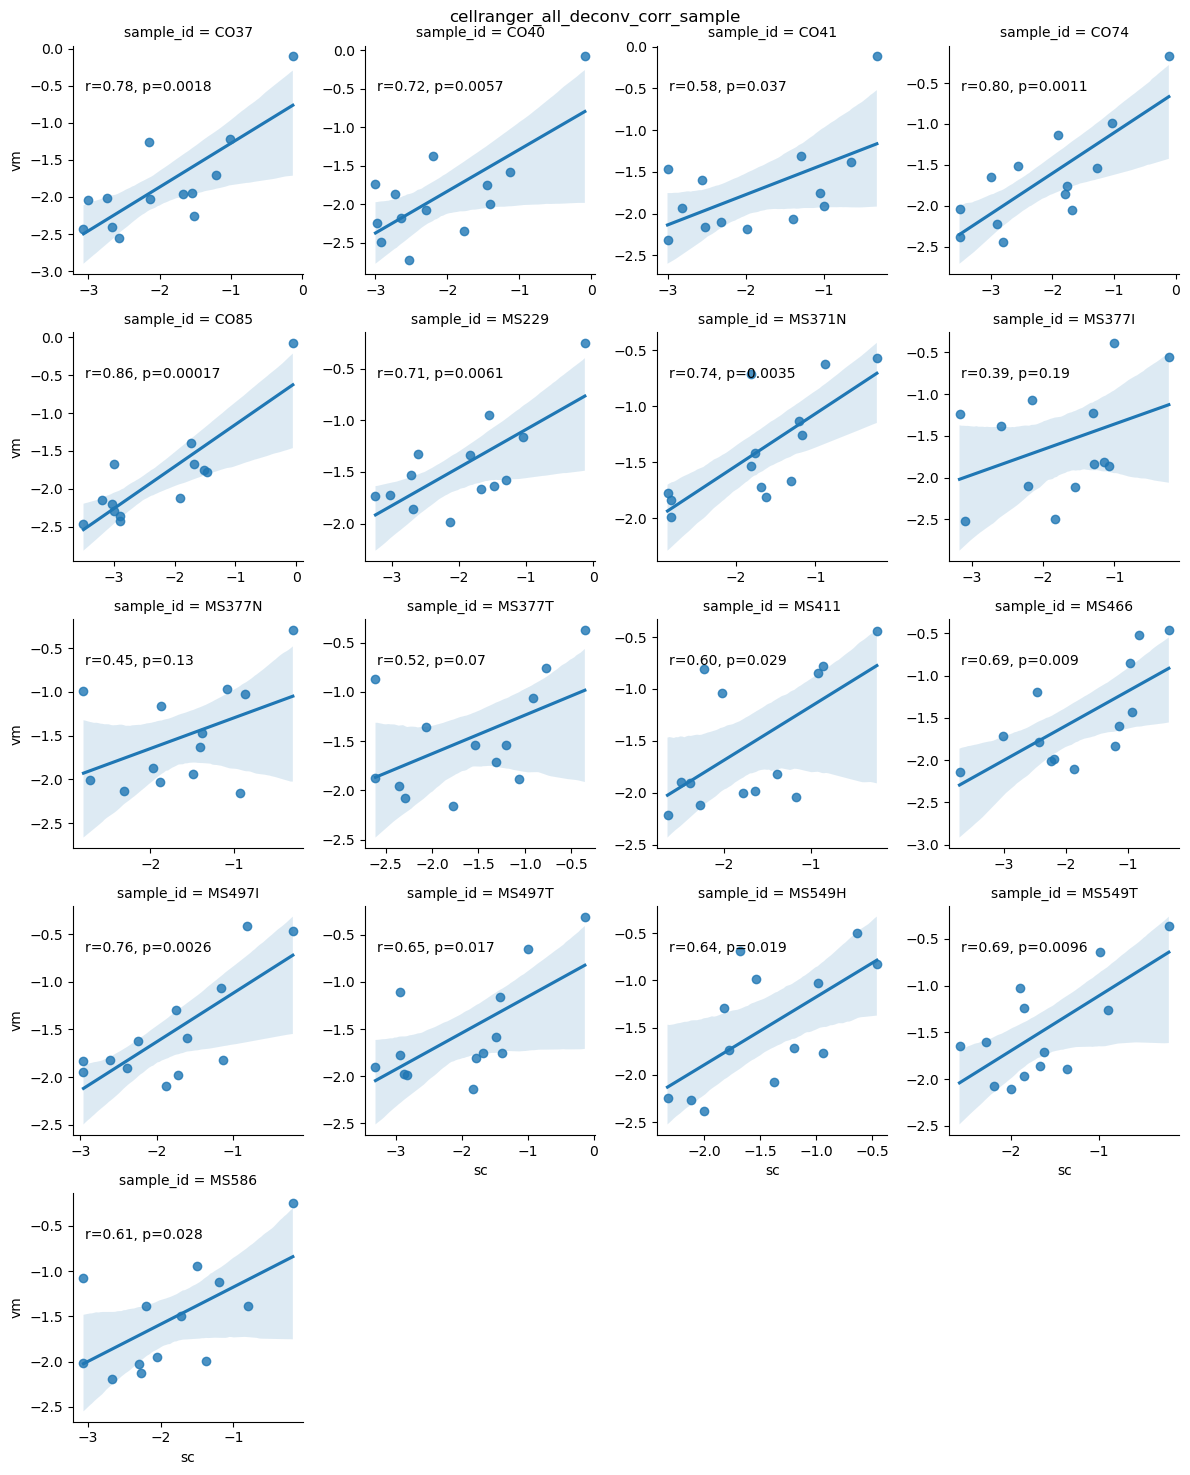

In [18]:
method = "cellranger"
model_call = "all"
plot_correlation(model_call, method, samples_oi, save_path=output_path, vis_proportions=vis_proportions, sc_proportions=sc_proportions)

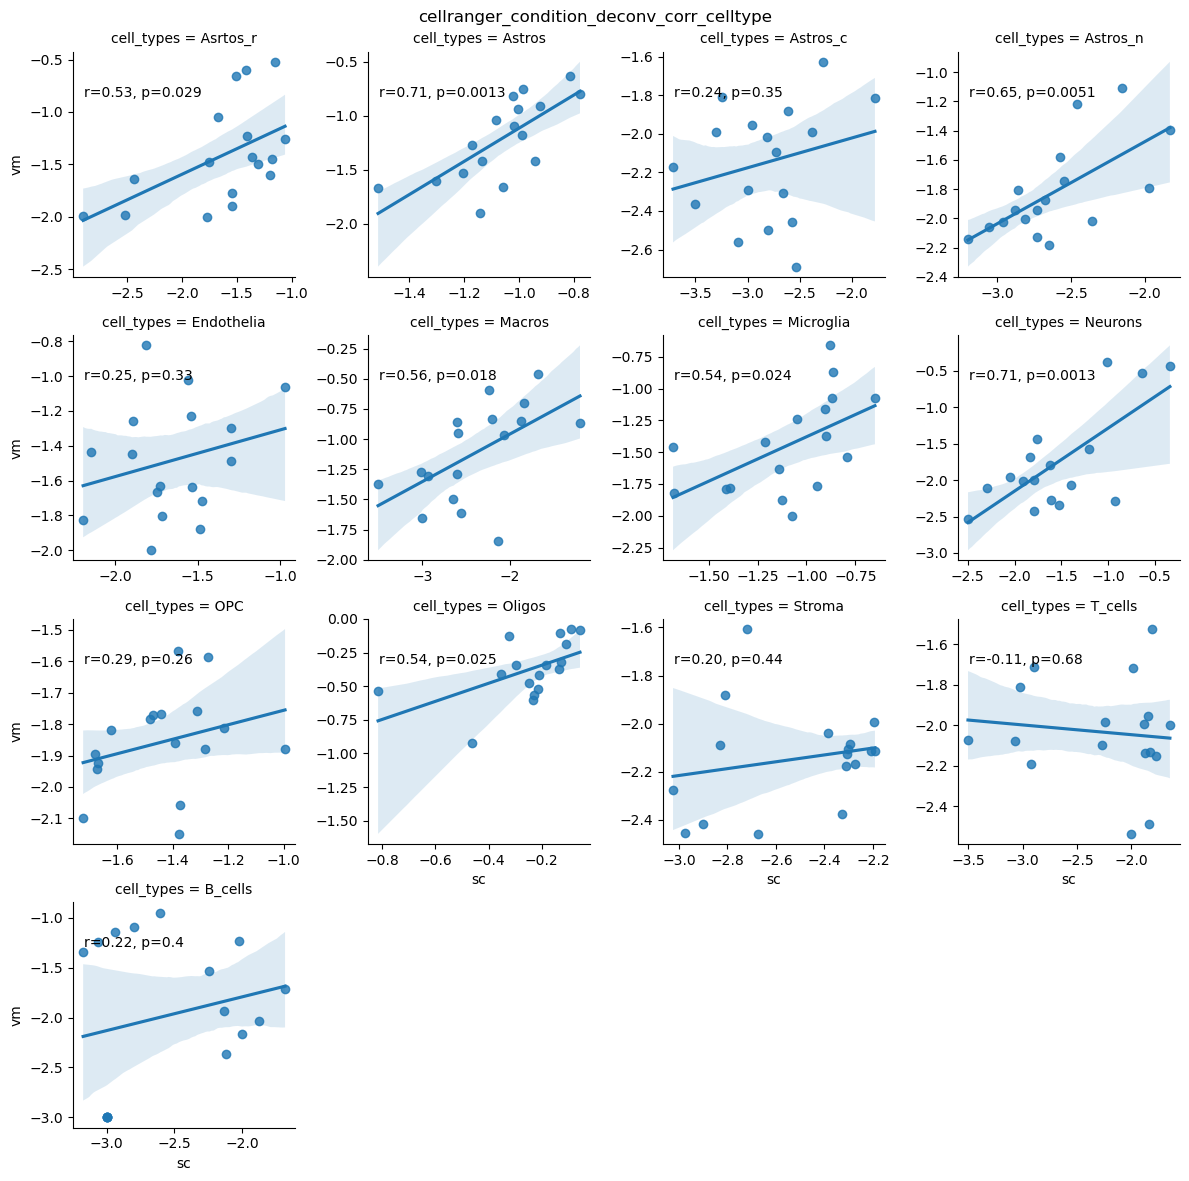

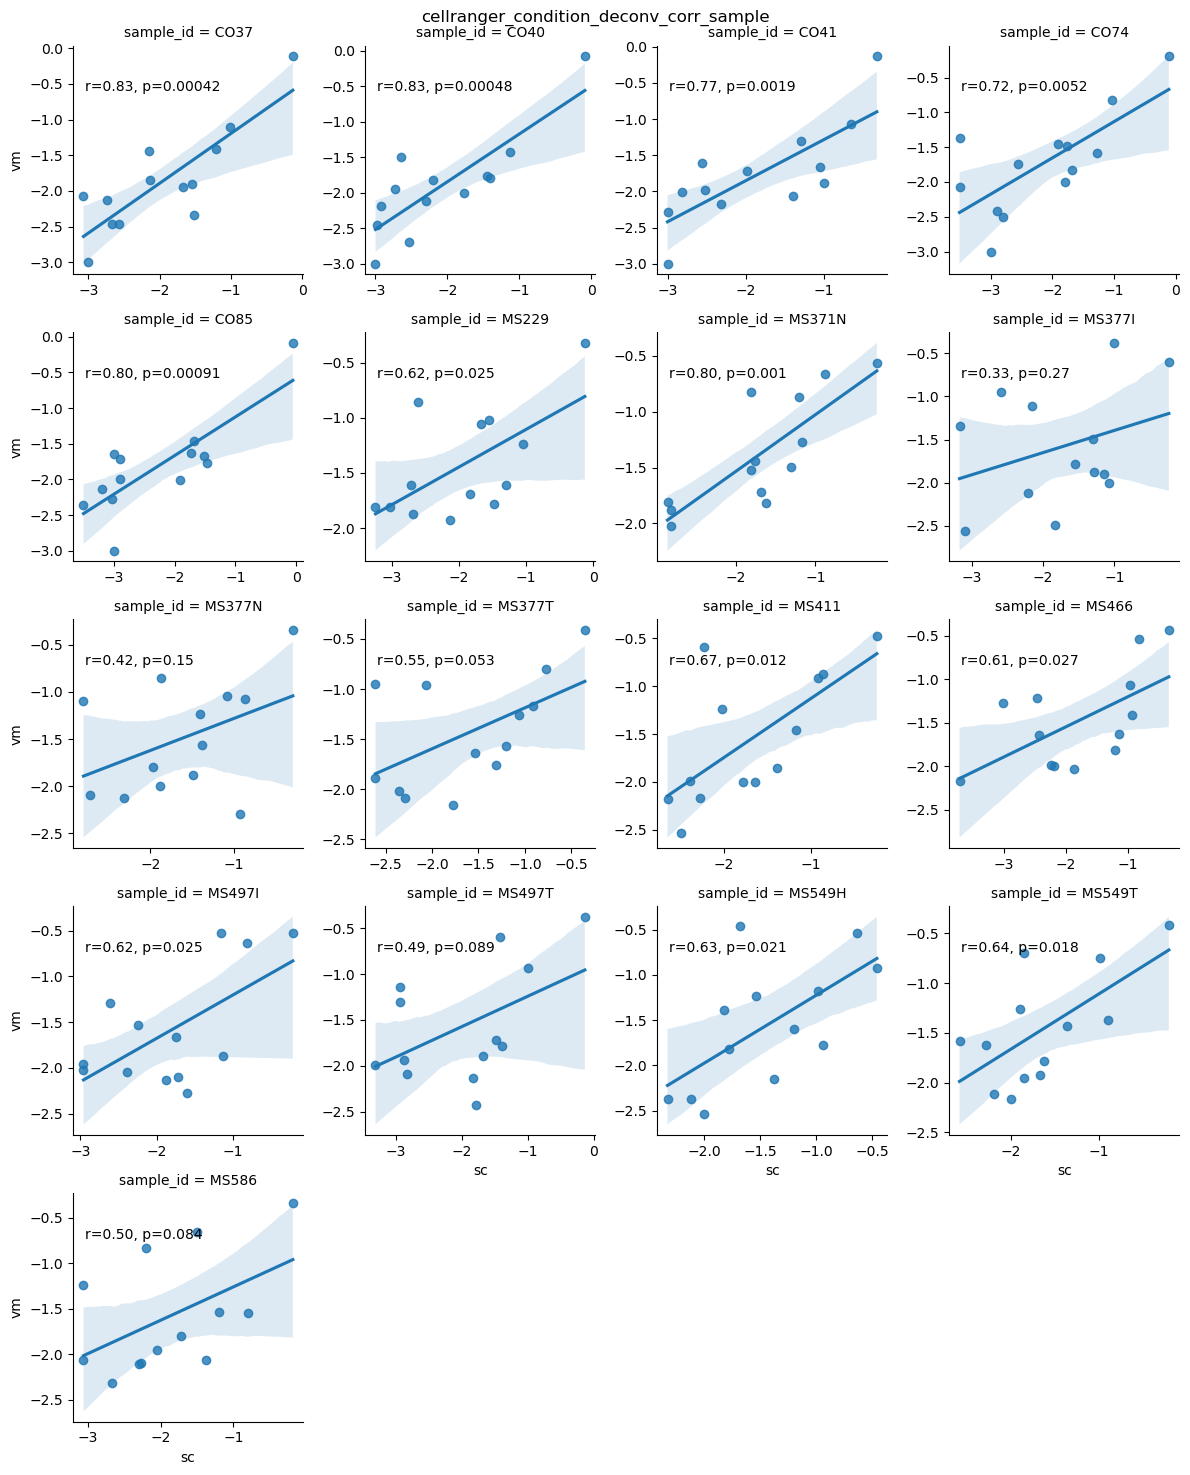

In [19]:
method = "cellranger"
model_call = "condition"
plot_correlation(model_call, method, samples_oi, save_path=output_path, vis_proportions=vis_proportions, sc_proportions=sc_proportions)

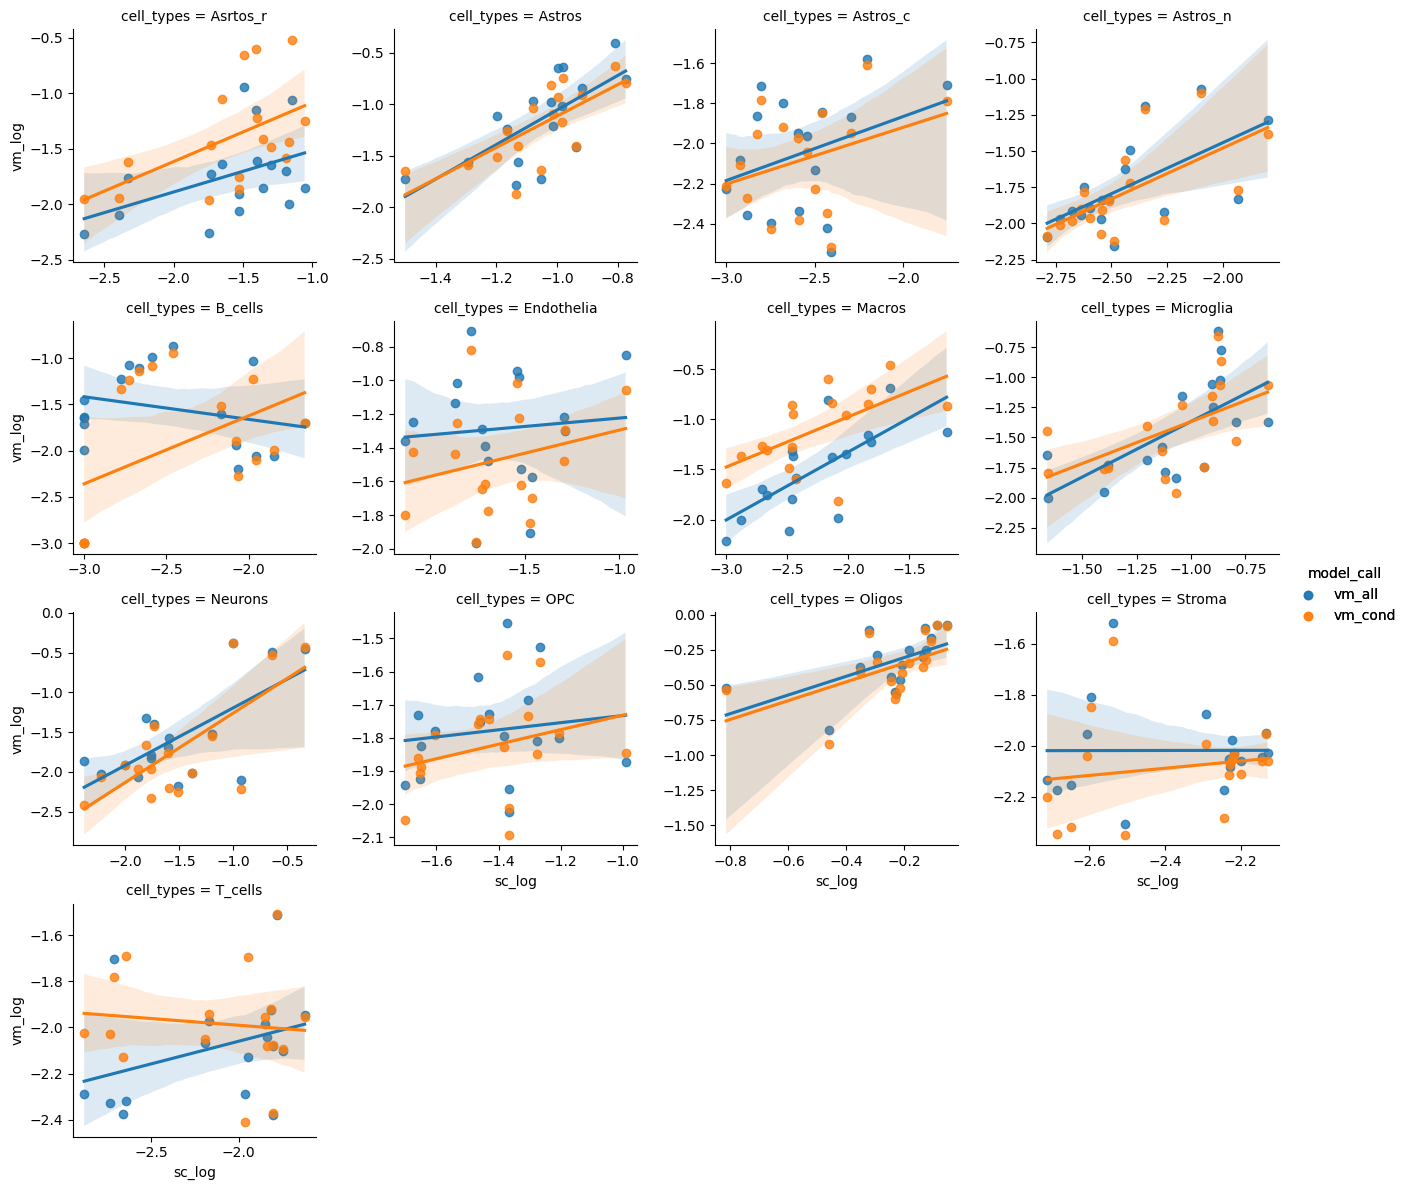

In [20]:
method = "cellranger"
epsilon = 0.001
point_estimate = "q05"

sc_prop = sc_proportions[method]
vis_prop_all = vis_proportions[method]["all"]
vis_prop_all.rename({"vm": "vm_all"}, inplace=True, axis=1)
vis_prop_cond= vis_proportions[method]["condition"]
vis_prop_cond.rename({"vm": "vm_cond"}, inplace=True, axis=1)

# only keep samples in sample_oi
sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
vis_prop_all = vis_prop_all.loc[vis_prop_all.sample_id.isin(samples_oi), :]
vis_prop_cond = vis_prop_cond.loc[vis_prop_cond.sample_id.isin(samples_oi), :]

# filter point estimate
vis_prop_all = vis_prop_all.loc[vis_prop_all.point_estimate == point_estimate, :].drop("point_estimate", axis=1)
vis_prop_cond = vis_prop_cond.loc[vis_prop_cond.point_estimate == point_estimate, :].drop("point_estimate", axis=1)

df = pd.merge(sc_prop, vis_prop_all, how='outer', on=['sample_id', 'cell_types'])
df = pd.merge(df, vis_prop_cond, how='outer', on=['sample_id', 'cell_types'])
df = df.fillna(0) 

df = pd.melt(df, id_vars=['sample_id', 'cell_types', 'sc'], value_vars=['vm_all', 'vm_cond'], var_name='model_call', value_name='vm')

df['sc_log'] = np.log10(df['sc'] + epsilon)
df['vm_log'] = np.log10(df['vm'] + epsilon)

# Plot corrs per cell type
g = sns.lmplot(x='sc_log', y='vm_log', data=df, col='cell_types', hue="model_call", col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
g.fig.set_facecolor('white')
g.add_legend()
plt.show()

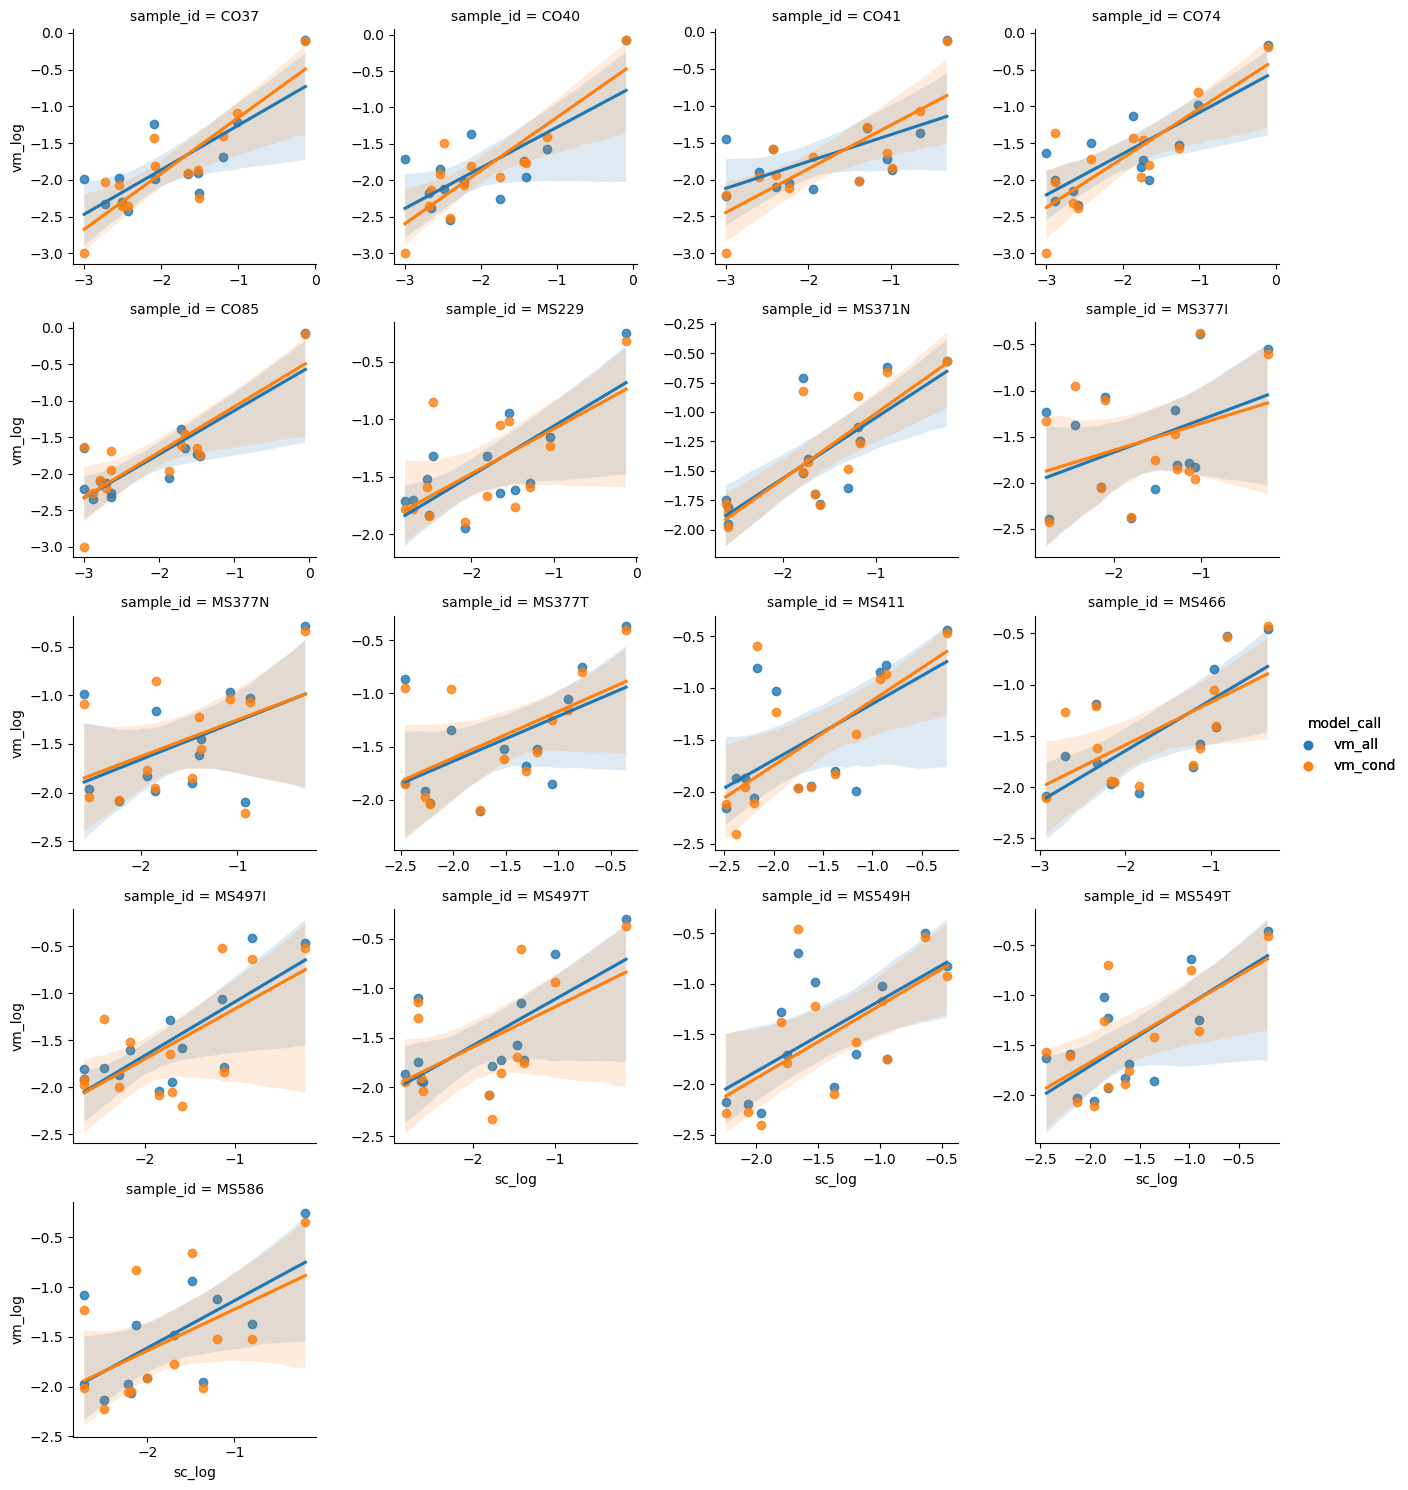

In [21]:
method = "cellranger"
epsilon = 0.001
point_estimate = "q05"

sc_prop = sc_proportions[method]
vis_prop_all = vis_proportions[method]["all"]
vis_prop_all.rename({"vm": "vm_all"}, inplace=True, axis=1)
vis_prop_cond= vis_proportions[method]["condition"]
vis_prop_cond.rename({"vm": "vm_cond"}, inplace=True, axis=1)

# only keep samples in sample_oi
sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
vis_prop_all = vis_prop_all.loc[vis_prop_all.sample_id.isin(samples_oi), :]
vis_prop_cond = vis_prop_cond.loc[vis_prop_cond.sample_id.isin(samples_oi), :]

# filter point estimate
vis_prop_all = vis_prop_all.loc[vis_prop_all.point_estimate == point_estimate, :].drop("point_estimate", axis=1)
vis_prop_cond = vis_prop_cond.loc[vis_prop_cond.point_estimate == point_estimate, :].drop("point_estimate", axis=1)

df = pd.merge(sc_prop, vis_prop_all, how='outer', on=['sample_id', 'cell_types'])
df = pd.merge(df, vis_prop_cond, how='outer', on=['sample_id', 'cell_types'])
df = df.fillna(0) 

df = pd.melt(df, id_vars=['sample_id', 'cell_types', 'sc'], value_vars=['vm_all', 'vm_cond'], var_name='model_call', value_name='vm')

df['sc_log'] = np.log10(df['sc'] + epsilon)
df['vm_log'] = np.log10(df['vm'] + epsilon)
# Plot corrs per cell type
g = sns.lmplot(x='sc_log', y='vm_log', data=df, col='sample_id', hue="model_call", col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
g.fig.set_facecolor('white')
g.add_legend()
plt.show()